# SVM + Planetary Computer

In this notebook we try to apply a typical machine learning algorithm (SVM - Support Vector Machine) from scikit-learn Python package to an Sentinel-2 imagery from Planetary Computer catalog. <br> Here we start recalling all import you need

In [1]:
import pystac
import planetary_computer
import rioxarray
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC

Firstly, we're going to fetch our data from Planetary Computer Catalog

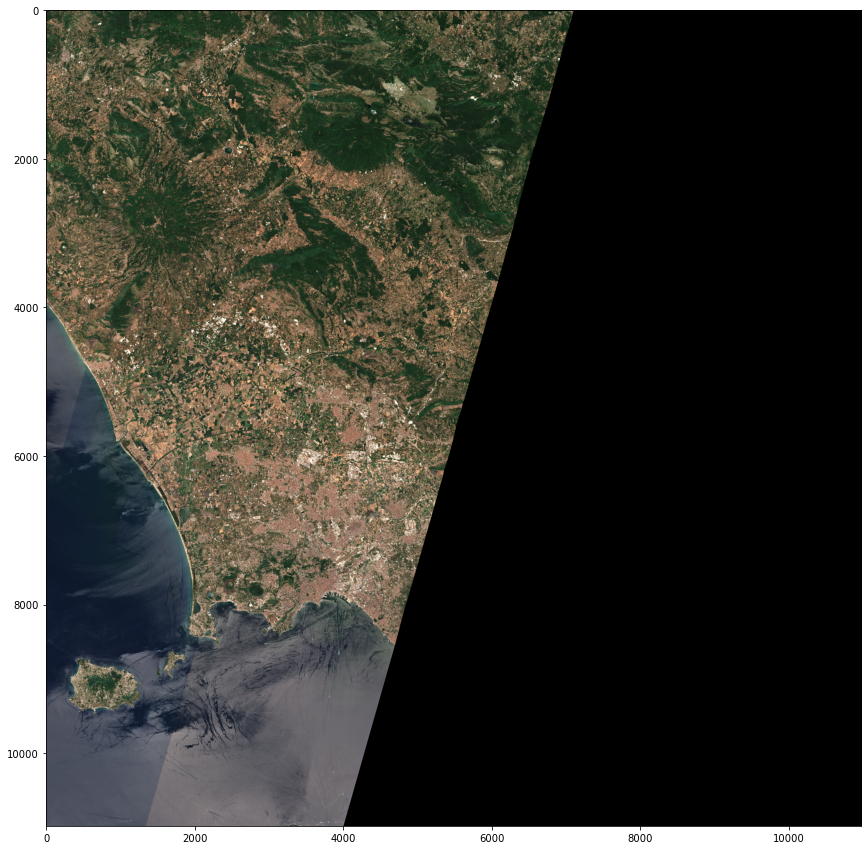

In [2]:
item_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2B_MSIL2A_20220719T095559_R122_T33TVF_20220719T204024"

# Load the individual item metadata and sign the assets
item = pystac.Item.from_file(item_url)
signed_item = planetary_computer.sign(item)

# Open one of the data assets (other asset keys to use: 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'SCL', 'WVP', 'visual')
asset_href = signed_item.assets["visual"].href
img = rioxarray.open_rasterio(asset_href).transpose("y","x","band")

plt.figure(figsize=(20,15))
plt.imshow(img)

Zoom on area of interest in order to have a fast classification processing 

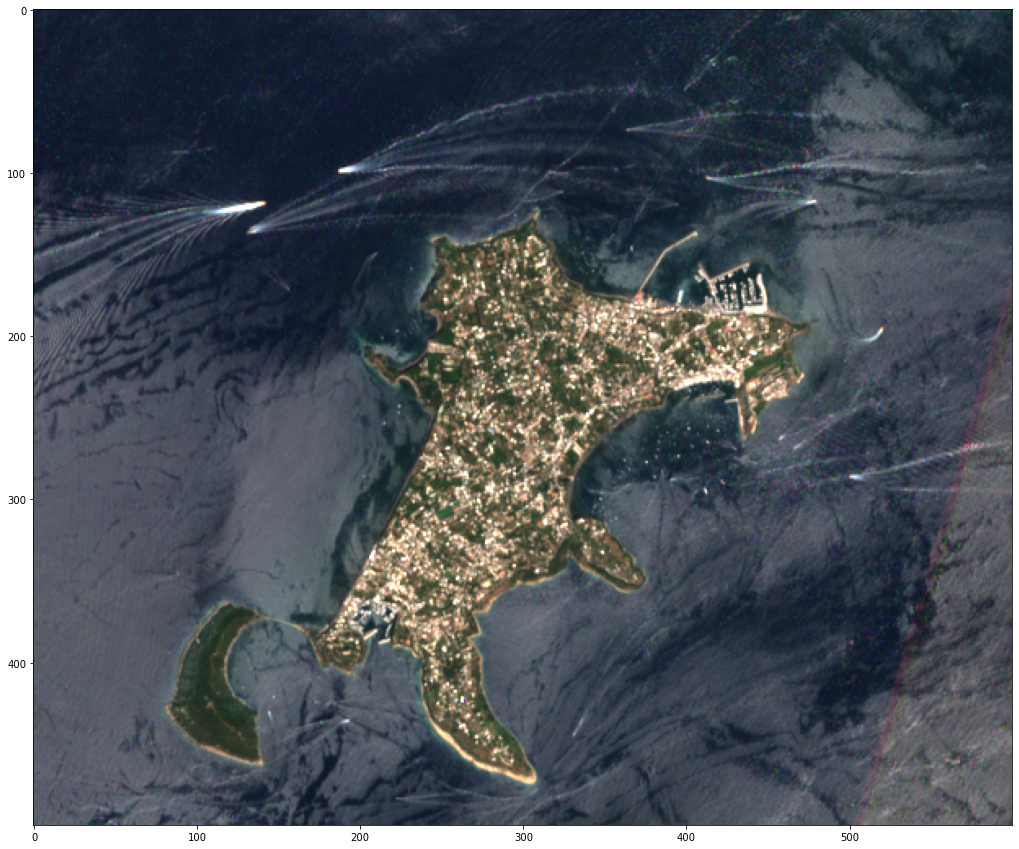

In [3]:
img = img[8500:9000,1400:2000]
plt.figure(figsize=(20,15))
plt.imshow(img)

# SVM Classification 

In [4]:
classes = {'buildings': 0, 'vegetation': 1, 'water': 2}
n_classes = len(classes)
palette = np.uint8([[255, 0, 0], [0, 255, 0], [0, 0, 255]])

In [5]:
rows, cols, bands = img.shape
X = img.data.reshape(rows*cols, bands)

We create a supervised object with same img shape and values of the classes. We start with values equal to n_classes (that is 3) and then we will apply the training classes to singles ROI. 


In [6]:
supervised = n_classes*np.ones(shape=(rows, cols), dtype=np.uint8)

Display zoom image to select the right ROI. Relation between ROI to classes

In [7]:
supervised[400:414,96:110] = classes['vegetation']
supervised[232:236,238:243] = classes['vegetation']
supervised[220:222,438:442] = classes['vegetation']
supervised[226:236,238:243] = classes['vegetation']
supervised[141:150,247:254] = classes['vegetation']
supervised[145:152,265:269] = classes['vegetation']
supervised[220:223,439:443] = classes['vegetation']
supervised[213:215,448:456] = classes['vegetation']
supervised[338:342,316:324] = classes['vegetation']

supervised[318:32,320:327] = classes['buildings']
supervised[225:227,407:410] = classes['buildings']
supervised[351:354,218:224] = classes['buildings']
supervised[360:363,210:211] = classes['buildings']
supervised[183:184,437:446] = classes['buildings']
supervised[225:226,307:310] = classes['buildings']
supervised[231:231,344:347] = classes['buildings']
supervised[376:380,239:247] = classes['buildings']


supervised[35:65,20:65] = classes['water']
supervised[140:170,490:550] = classes['water']
supervised[310:345,13:60] = classes['water']
supervised[348:355,322:343] = classes['water']


Create a vector array by applying  ravel() functions to supervised matrix. It returns contiguous flattened array in order to create our target for train and test pixels.

In [8]:
y = supervised.ravel()

Apply flatnonzero function which Return indices that are non-zero in the flattened version of supervised array. We call train indices all indices between 0 and 2, test indices are with class equals to 3.

In [9]:
train = np.flatnonzero(supervised < n_classes)
test = np.flatnonzero(supervised == n_classes)

Normally for a good classification the data is divided into train and test data in the ratio of 30:70. As this is only a training, we can accept low rate for the ratio.

In [10]:
len(train)/len(test)*100

1.8371420424457208

Now we are ready to recall a SVC classifier with a linear kernel (we can try  ‘linear’, ‘rbf’, ‘sigmoid’, ‘precomputed’ as well ) 

In [11]:
clf = SVC(kernel='poly')
clf.fit(X[train], y[train])
y[test] = clf.predict(X[test])

Reshaping and plotting the result:

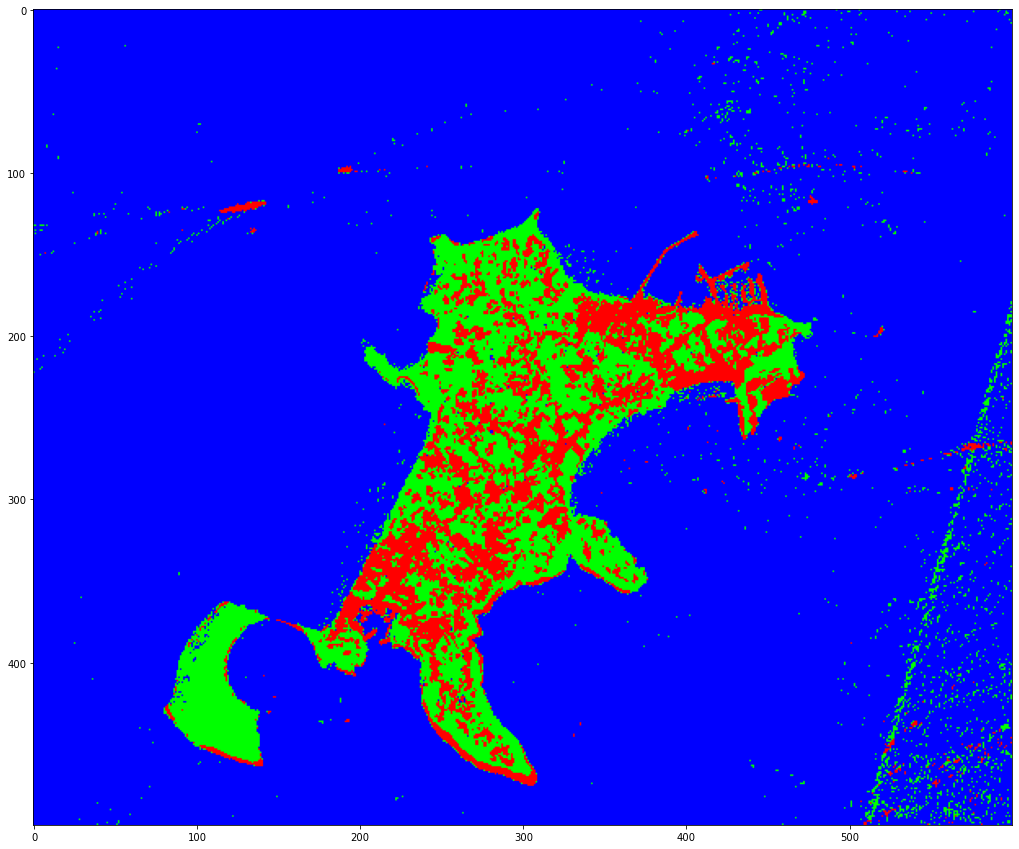

In [12]:
supervised_svm = y.reshape(rows, cols)

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.imshow(palette[supervised_svm])
plt.show()